<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 1
<br>
<b>Deadline:</b> May 13, 2020 (Wednesday) 23:00
</div>

# Exercise 9.1. Bottleneck autoencoders

The goal of this exercise is to get familiar with bottleneck autoencoders.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

In this exercise, we use the standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Minmax normalization to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

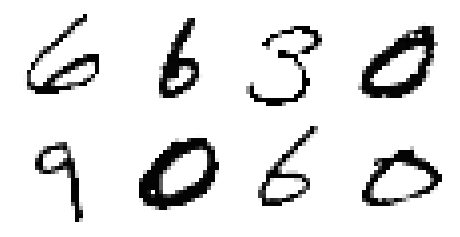

In [8]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Train a deep autoencoder

We train a deep autoencoders with only fully-connected layers.

## Encoder

Our encoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with `n_components` outputs

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=n_components)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        return x

In [10]:
def test_Encoder_shapes():
    n_components = 2
    encoder = Encoder(n_components)
    
    x = torch.randn(3, 1, 28, 28)
    y = encoder(x)
    assert y.shape == torch.Size([3, n_components]), f"Bad y.shape: {y.shape}"
    print('Success')

test_Encoder_shapes()

Success


## Decoder

Our decoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 784 outputs

In [11]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        super(Decoder, self).__init__()
        self.n_components = n_components
        self.decoder = nn.Sequential(
            nn.Linear(n_components, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
        )

    def forward(self, x):
        out = self.decoder(x)
        out = out.view(x.size(0), 1, 28, 28)
        return out

In [12]:
def test_Decoder_shapes():
    n_components = 2
    decoder = Decoder(n_components)
    
    x = torch.randn(3, n_components)
    y = decoder(x)
    assert y.shape == torch.Size([3, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
    print('Success')

test_Decoder_shapes()

Success


# Train a bottleneck autoencoder

We will use the bottleneck autoencoder to encode MNIST images into 10-dimensional representations.

In [13]:
# Create a deep autoencoder
n_components = 10
encoder = Encoder(n_components)
encoder.to(device)

decoder = Decoder(n_components)
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=784, bias=True)
  )
)

### Training loop

Implement the training loop in the cell below. In the training loop, the training data are first encoded into lower-dimensional representations using the encoder. Then, the decoder is used to produce the reconstructions of the original images from the lower-dimensional code. We will use the `MSELoss` to measure the reconstruction error, which is minimized during training.

The recommended hyperparameters:
* Adam optimizer with learning rate 0.001

Hints:
- Training usually converges fast, four epochs is usually enough.
- The loss at convergence should be close to 0.066.

In [14]:
# Training loop
if not skip_training:
    train_loss = []
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(parameters, lr=0.001)
    criterion = nn.MSELoss()
    encoder.train()
    decoder.train()
    
    for epoch in range(4):
        running_loss = 0.0
        for _, data in enumerate(trainloader):
            optimizer.zero_grad()
            images, _ = data
            encoded = encoder(images)
            decoded = decoder(encoded)
            loss = criterion(decoded, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print(f"Epoch: {epoch+1} - Train Loss: {loss}")
    

Epoch: 1 - Train Loss: 0.13141725779771804
Epoch: 2 - Train Loss: 0.0797882769147555
Epoch: 3 - Train Loss: 0.07063675572872162
Epoch: 4 - Train Loss: 0.06598901677131652


In [15]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(encoder, '9_ae_encoder.pth')
    tools.save_model(decoder, '9_ae_decoder.pth')
else:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, '9_ae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, '9_ae_decoder.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 9_ae_encoder.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 9_ae_decoder.pth.


### Visualize embeddings

Let us visualize the latent space in the cell below. If your autoencoder does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE


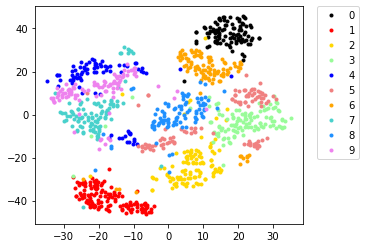

In [16]:
tests.visualize_embeddings(encoder, trainloader, n_samples=1000, device=device)

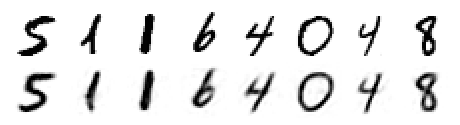

In [17]:
# Let's visualize test images and their reconstructions using the trained autoencoder
tests.visualize_reconstructions(encoder, decoder, trainloader, device=device)

## Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [18]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [19]:
# Encode data samples using the encoder
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    with torch.no_grad():
        embeddings = []
        labels = []
        for images, labels_ in dataloader:
            embeddings.append(encoder(images.to(device)))
            labels.append(labels_)

        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)
    return embeddings, labels

traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)

In [20]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .85, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 89.94%
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we reduced the dimensionality of the MNIST data from $28 \times 28 = 784$ to $10$ using a bottleneck autoecoder. Using a very simple linear classifier, we were able to classify the encoded images with a good accuracy, which is the evidence that the structure of the data is well preserved in the embedding space.